In [1056]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import pdir as pr
import pandas as pd
import os
from tqdm import tqdm, tnrange, tqdm_notebook

DF = pd.DataFrame

# 数据集预处理

此次实验数据集来源于[UCI Machine Learning Database][1]，在原始数据集上的基础上，我们用hour.csv中的一部分数据作为训练集（第1-8619条数据，命名为train.csv），一部分数据作为测试集（第16876-17379条数据，命名为test.csv）。

其中，数据集特征命名的解释如下：

```
=========================================
Dataset characteristics
=========================================	

	- instant: record index
	- dteday : date
	- season : season (1:springer, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2011, 1:2012)
	- mnth : month ( 1 to 12)
	- hr : hour (0 to 23)
	- holiday : weather day is holiday or not 
    (extracted from http://dchr.dc.gov/page/holiday-schedule)
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, 
        Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : Normalized temperature in Celsius. The values are divided to 41 (max)
	- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
	- hum: Normalized humidity. The values are divided to 100 (max)
	- windspeed: Normalized wind speed. The values are divided to 67 (max)
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered
	


```
[1]:https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

## 读取训练集和测试集

In [1057]:
trainSet_origin = pd.read_csv('data\\train.csv')
testSet_origin = pd.read_csv('data\\test.csv')
trainSet_origin.shape, testSet_origin.shape

((8619, 15), (504, 15))

## 数据集预览

这里先输出训练集的前5个数据进行数据预览。可以看到，TA给的数据集去除了casual和registered这个两个特征。

In [1058]:
trainSet_origin.head(5)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011/1/1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011/1/1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011/1/1,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011/1/1,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011/1/1,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


## 特征预处理以及特征归一化/标准化

结合上面数据集特征命名的解释，我们可总结如下结论：

- **season, mnth, weekday, hr, weathersit, yr, holiday这7个特征都是类别特征(categorical feature)**，这类特征的各个取值并**不存在着取值上的“大小”关系（更严格来说，不存在“序”的关系）**，比如season有4种取值1、2、3、4，但是从该特征的含义上来讲这4种取值之间并没有“序”(order)的关系，因此要使用**独热编码**的方式来讲season特征**替代划分**为4个特征，比如名为season_1、season_2、season_3、season_4，这些引入的变量也称为**哑变量(Dummy variables)**，这样才可以**避免因强行给类别数据增加“序”而带来的许多问题**。

    - 由于yr, holiday只有两个值，依旧用0或者1表示即可。
    
    - season, mnth, weekday, hr, weathersit这5个特征就用**独热编码**的方式**替代划分**为多个特征


- 以下是几个**对训练神经网络没有意义或者重复的特征，这类特征应直接删除掉**。

    - instant特征只是记录的序号，这并不能给我们提供什么信息。
    
    - dteday特征只是记录的日期，时间信息对我们训练神经网络也没有什么意义。
    
    - workingday特征与holiday、weekday这两个特征有重复的地方，不能提供额外的信息。
    
    - atemp特征是受temp特征影响的，其不能提供temp特征所不能提供的信息。


- 除去重复的特征，以下对几个**连续型特征的归一化/标准化**问题的讨论。
    
    - 原始数据集中已经归一化的特征：
    
        - temp特征：代表的是摄氏温度，其通过除以最大值41进行归一化。由于温度的实际最大值应是不会与41度差别太大，这样归一化方式还是合理的。具体考证方法还是要看当地的气候，这个还是不要太较真。
        
        - hum特征：代表湿度，其通过除以最大值100进行归一化，这是完全正确的。
        
        - windspeed特征：代表风速，其通过除以最大值67进行归一化。由于风速的实际最大值应是不会与67差别太大，这样归一化方式推测是合理的。具体考证方法还是要看当地的气候，这个还是不要太较真。
        
    - 原始数据集中未归一化的特征：
    
        - cnt特征：目标预测值，代表预测的一个小时的单车租赁量。这个是没有进行归一化/标准化的特征，所以还是要先进行归一化/标准化比较妥当，而又**由于一个小时的单车租赁量的最大值是不明确的，因此z-score标准差标准化对该特征进行处理，其适用于属性A的最大值和最小值未知的情况，或有超出取值范围的离群数据的情况**。对应转化函数为：$$X^{*}=\frac{X-mean(X)}{std(X)}$$


### 合并训练集和测试集
由于后续需要对训练集和测试集都进行同样的数据处理，在处理过程中可能会涉及到数据集维度的变化，因此这里事先把两个数据集合并起来，以免后续因为维度不统一而出现问题。

In [1059]:
allDataSet_origin = pd.concat([trainSet_origin, testSet_origin], axis=0)
allDataSet.shape

(9123, 57)

### 特征预处理

In [1060]:
def featurePreprocessing(dataSet):
    '''特征预处理：替代类别特征为哑变量、去除无关特征'''
    categorical_features = ['season', 'mnth', 'weekday', 'hr', 'weathersit']
    useless_features = ['instant', 'dteday', 'workingday', 'atemp']
    features2drop = categorical_features + useless_features 

    for feature in categorical_features:
        #创键 哑变量
        dummies = pd.get_dummies(dataSet[feature], prefix=feature, drop_first=False)
        #合并数据集
        dataSet = pd.concat([dummies, dataSet], axis=1)
        
    #去除类别特征以及无关特征
    return dataSet.drop(features2drop, axis=1)
    
allDataSet = featurePreprocessing(allDataSet_origin.copy())
allDataSet.shape

(9123, 57)

### 还原训练集和测试集
对两个数据集要一并处理的步骤已经完成，这里先把两个数据集分开回去。

In [1061]:
divideLine = testSet_origin.shape[0]
trainSet = allDataSet[:-divideLine].astype('float64')
testSet = allDataSet[-divideLine:].astype('float64', raise_on_error=False)
trainSet.shape, testSet.shape

((8619, 57), (504, 57))

In [1062]:
assert(trainSet.shape[0] == trainSet_origin.shape[0])
assert(testSet.shape[0] == testSet_origin.shape[0])

### 预处理效果预览

这里先输出预处理后的前5个数据，可见数据的特征数目上涨了许多个。

In [1063]:
trainSet.head()

,weathersit_1,weathersit_2,weathersit_3,weathersit_4,hr_0,hr_1,hr_2,hr_3,hr_4,hr_5,...,season_1,season_2,season_3,season_4,yr,holiday,temp,hum,windspeed,cnt
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.81,0.0,16.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.22,0.80,0.0,40.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.22,0.80,0.0,32.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.75,0.0,13.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.75,0.0,1.0


输出所有的特征名称，可见类别变量均被哑变量替换了，无关变量也被删除了。

In [1064]:
trainSet.columns

Index(['weathersit_1', 'weathersit_2', 'weathersit_3', 'weathersit_4', 'hr_0',
       'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9',
       'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17',
       'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6', 'mnth_1', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6',
       'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12',
       'season_1', 'season_2', 'season_3', 'season_4', 'yr', 'holiday', 'temp',
       'hum', 'windspeed', 'cnt'],
      dtype='object')

### 从训练集中划分验证集

典型的从训练集中划分验证集的方法是：划分训练集中的18%为验证集，划分过程采用随机选取的方式。但是这里**由于数据是有时间序列特性的，因此便采取划分训练集的后18%为验证集**。

In [1065]:
trainSet_backup = trainSet.copy()

In [1066]:
splitRate = 0.18 #划分比例
splitNum = int(trainSet_backup.shape[0]*splitRate) #划分的数目
#划分 数据集 和 标签
temp = trainSet_backup.drop(['cnt'], axis=1), trainSet_backup['cnt']
#得到 训练集 和 标签
trainSet, trainSet_label = temp[0][:-splitNum].values, temp[1][:-splitNum].values 
#得到 验证集 和 标签
validateSet, validateSet_label = temp[0][-splitNum:].values, temp[1][-splitNum:].values

print('划分后的训练集和验证集的维度：', trainSet.shape,  validateSet.shape)

划分后的训练集和验证集的维度： (7068, 56) (1551, 56)


### 特征归一化/标准化

这里对训练集的特征cnt需要进行标准化，并保存标准化时该特征数据的均值和方差，以供后续预测时还原数据使用。

In [1067]:
trainSet_label.mean(), trainSet_label.std() #处理前的均值和方差

(147.08899264289758, 137.21696136234789)

In [1068]:
mean_of_cnt, std_of_cnt = trainSet_label.mean(), trainSet_label.std()
trainSet_label = (trainSet_label - mean_of_cnt)/std_of_cnt

同时，也需要用从验证集得到的均值和方差对验证集进行标准化。这里很容易犯的一个错误就是：先对数据集进行标准化再划分数据集为训练集和验证集。正确的做法应该是：先划分数据集为训练集和验证集，再对训练集进行标准化，使用从训练集得到的标准化的均值和方差来对验证集进行标准化。

In [1069]:
validateSet_label = (validateSet_label - mean_of_cnt)/std_of_cnt

下面来输出两个数据集的基本数据特征，以供分析。

In [1070]:
pd.concat([DF(trainSet_label).describe(), DF(validateSet_label).describe()], axis=1)

,0,0
count,7.068000e+03,1551.000000
mean,-3.157350e-15,-0.128275
std,1.000071e+00,0.848122
min,-1.064657e+00,-1.064657
25%,-8.387374e-01,-0.875176
50%,-2.630068e-01,-0.306733
75%,5.094925e-01,0.356450
max,3.672367e+00,2.958169


## 去除测试集的无关数据

测试集最后一列（也即是cnt特征那一列）全部都是问号，这里便将其最后一列删除，以适应后续算法的数据要求。

In [1071]:
testSet = testSet.drop(['cnt'], axis=1)
testSet.shape

(504, 56)

这里验证测试集和训练集的特征个数是否一致，以确保后续根据训练集训练算法后可应用于测试集。

In [1072]:
assert(testSet.shape[1] == trainSet.shape[1])

## 保存预处理后的数据集

In [1073]:
dirPath = "proprocessed data"
if not os.path.exists(dirPath):
    os.mkdir(dirPath)
    
DF(trainSet).to_csv(dirPath + '\\train.csv')
DF(testSet).to_csv(dirPath + '\\test.csv')

# 神经网络算法

## 算法原理

### 基本介绍

本次实验实现的是BP神经网络，也称为**误差反向传播算法** (Error Back Propagation)。

其首先借鉴了PLA使用$$y = W^Tx+b$$来线性划分数据集的思想，可以说神经网络的单个神经元就是一个PLA分类器的“缩影”，其通过组合多个神经元来实现划分更多单个PLA分类器无法划分的数据集的目标。

但是，又由于多个线性分类器的叠加本质上终究是线性的，为了处理线性不可分的情况，神经网络中便引入了激活函数来增加非线性因素。常用的激活函数有sigmoid函数、reLU函数、Maxout函数等等。以sigmoid函数为例，此时单个神经元就变成了这样的一个分类器：$$y = f(x) = sigmoid(W^Tx+b)$$

这样，多个非线性分类器的叠加在理论上就可以完美地划分任意非线性的数据集了。

好，那么问题来了，到底要怎样**“组合”**单个神经元呢？神经网络采用了如下的方法：让多个神经元排列成一层，除了输入层之外每层神经元都接收前面一层所有神经元的输入$$W^TX=x_1*w_1+x_2*w_2+...+xn*w_n$$，这里$x_i$便是上一层神经元的输出，$w_i$就是上一层神经元的数据传播到下一次神经元的权重，每个神经元通过上面提到的激活函数将输入转换为输出$y$，该过程不断迭代直到到达输出层。这个过程也称为**前向传播**过程。

那么，很自然的，该如何去训练$W$和$b$这些参数呢？这时候就要讲起误差反向传播算法的核心了。

首先，BP算法先随机初始化网络中的权重$W$和偏置$b$。在给定一些数据的前提下，对于每一个数据，BP算法先通过前向传播计算预测值，然计算预测值和对应实际值的误差，**逆向反馈更新神经网络中每条连接线的权重$W$和偏置$b$**。

在没有到达停止条件的情况下重复上述过程。停止条件可以是下面这三条

- 权重的更新低于某个阈值的时候
- 预测的错误率低于某个阈值
- 达到预设一定的迭代次数

举个例子，在手写数字识别中，一张手写数字1的图片储存了 28 * 28 = 784个像素点，每个像素点储存着灰度值(值域为[0,255])，那么就意味着有784个神经元作为输入层，而输出层有10个神经元代表数字0 - 9，每个神经元取值为0 - 1，代表着这张图片是这个数字的概率。

每输入一张图片（也就是实例），神经网络会执行前向传输一层一层的计算到输出层神经元的值，根据哪个输出神经元的值最大来预测输入图片所代表的手写数字。然后根据输出神经元的值，计算出预测值与真实值之间的误差，再逆向反馈更新神经网络中每条连接线的权重和每个神经元的偏置。

后续会使用到一些符号，这里先统一进行解释：

- $N_i$ 表示第 i 层神经元的个数，其中$1\leqq i \leqq l$；

- $f(·)$ 表示神经元的激活函数；

- $W^i \in R^{N_{i-1}\  \times\  N_{i}}$ 表示第 $i-1$ 层到第 $i$ 层的权重矩阵；
 
- $w_{jk}^{i}$是权重矩阵 $W^i$ 中的元素，表示第 $i-1$ 层第 $j$ 个神经元到第 $i$ 层第 $k$ 个神经元的连接的权重；

- $\textbf{z}^i=[z_1^i,z_2^i,...,z_{N_i}^i]^T \in  R^{N_{i}\  \times\  1}$表示第 $i$ 层神经元的输入；

- $\textbf{a}^i=[a_1^i,a_2^i,...,a_{N_i}^i]^T \in  R^{N_{i}\  \times\  1}$表示第 $i$ 层神经元的输出；

- $\textbf{y}=[y_1,y_2,...,y_{N_l}]^T \in  R^{N_{l}\  \times\  1}$表示数据的实际标签；

- $\widehat{\textbf{y}}=[\widehat{y}_1,\widehat{y}_2,...,\widehat{y}_{N_l}]^T \in  R^{N_{l}\  \times\  1}$表示输出神经元的输出；

为方便解释和实现，这里不讨论有关偏置项$b$的使用，即是默认偏置项为0。

### 前向传播

前向传播的过程比较简单，对于第 $i(2 \leqq i \leqq l)$ 层的神经元，其输入为：

$$\textbf{z}^i=a^{i-1}*W^i$$

对应输出为：

$$\textbf{a}^i=f(\textbf{z}^i)$$

对于$l$层感知器（即是每一层神经元只有一个），前向传播的过程如下：

$$X=\textbf{a}^1 \rightarrow \textbf{z}^2 \rightarrow \textbf{a}^2 \rightarrow \ ... \ \rightarrow \textbf{a}^{l-1} \rightarrow \textbf{z}^l\rightarrow \textbf{a}^l = \textbf{y}  $$



### 误差反向传播

假设训练数据为$D={(X_1,y_1),(X_2,y_2),...,(X_n,y_n)}$，即共有 $n$ 个。

对于某个训练数据$(X_i,y_i)$，其代价函数为：

$$E_i=\frac{1}{2}\sum_{k=1}^{N_l}{(y_k^i-\widehat{y}_k^i)}^2$$

显然，所有训练数据的总体（平均）代价可写为：

$$E_{total} = \frac{1}{n}\sum_{i=1}^{n}E_i$$

算法的目标就是调整权重和偏置使总体代价（误差）变小，求得总体代价取最小值时对应的各个神经元的参数（即权重和偏置）。

这里，便可使用梯度下降法来进行参数的更新了。

则第 $i-1$ 层到第 $i$ 层的权重矩阵的更新式写为：

$$W_i = W_i - \eta \frac{\partial E_{total}}{\partial W_i}=                                    W_i -\frac{\eta}{n}\sum_{j=1}^n \frac{\partial E_{j}}{\partial W_i}$$

对于单个误差的梯度，有：

$$\frac{\partial E_{j}}{\partial W_i}=\delta^{i}*a^{i-1}$$

其中，输出层的误差梯度矩阵${\delta}^{i}$为：

$${\delta}^{l}=(\textbf{y}-\widehat{\textbf{y}}) \odot f'(z^{l})$$

隐藏层的误差梯度矩阵${\delta}^{i}$为：

$${\delta}^{i}=(W^{i+1}*\delta^{i+1})\odot f'(z^{i})$$

这里符号$\odot$为Hadamard乘积，符号$*$为常规矩阵运算。

具体流程见下面伪代码。


## 算法伪代码

---

**神经网络算法**

---
**输入**：训练集$D={(X_1,y_1),(X_2,y_2),...,(X_n,y_n)}$、各个网络层的结点个数、梯度下降的步长$\eta$、算法迭代次数$maxRunTimes$

**输出**：各个层之间的最优权重矩阵$W$

---
用均值为0，标准差为$\frac{1}{\sqrt{N_{in}}}$的正态分布初始化每层之间的权重矩阵$W_{N_{in} \times N_{out}}^{(i)}$，其中$1\leqq i \leqq l$, $l$为网络的层数(不包括输入层)，$N_{in}$为对应层的输入元素个数，$N_{out}$为对应层的输出元素个数

$for\ t\ =\ 1,2,...,maxRunTimes\ do$

$\ \ \ \ \ $初始化每一层之间的权重更新矩阵${\bigtriangledown W}_{N_{in} \times N_{out}}$元素全为0

$\ \ \ \ \ for\ (X, \textbf{y}) \in D \ do$

$\ \ \ \ \ \ \ \ \ \ $计算当前样本的输出值$\widehat{\textbf{y}}=X*W^{1}*\ ...\ *W^{l}$

$\ \ \ \ \ \ \ \ \ \ $计算输出层的误差梯度矩阵${\delta}^{l}=(\textbf{y}-\widehat{\textbf{y}}) \odot f'(z^{l})$

$\ \ \ \ \ \ \ \ \ \ $计算隐藏层的误差梯度矩阵${\delta}^{i}=(W^{i+1}*\delta^{i+1})\odot f'(z^{i})$，其中$1\leqq i \leqq l-1$

$\ \ \ \ \ \ \ \ \ \ $更新每层之间的权重更新矩阵${\bigtriangledown W^i}_{N_{in} \times N_{out}}={\bigtriangledown W^i}_{N_{in} \times N_{out}}+\delta^{i}*a^{i-1}$，其中$1\leqq i \leqq l$

$\ \ \ \ \ endfor$

$\ \ \ \ \ $使用$W_{N_{in} \times N_{out}}=W_{N_{in} \times N_{out}}+\eta\frac{{\bigtriangledown W}_{N_{in} \times N_{out}}}{n}\ $更新权重矩阵

$endfor$

---

## 神经网络类实现

In [1074]:
class NeuralNetwork(object):
    '''神经网络类实现'''
    def __init__(self, n_input, n_hidden, n_output, learning_rate, SGD_batch_size=-1):
        '''初始化函数'''
        #设置 输入层、隐藏层、输出层结点个数
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.n_output = n_output
        #设置 学习率
        self.lr = learning_rate
        #设置 激活函数
        self.activation_function = lambda x : 1/(1+np.exp(-x))
        #设置随机梯度下降每次抽取的样本个数，-1代表使用 批梯度下降
        self.SGD_batch_size = SGD_batch_size
        
        #初始化 输入层到隐藏层、隐藏层到输出层的权重矩阵为正态分布
        self.weights_input_to_hidden = np.random.normal(0, self.n_input**(-0.5),
                                                        (self.n_input, self.n_hidden))
        self.weights_hidden_to_output = np.random.normal(0, self.n_hidden**(-0.5),
                                                         (self.n_hidden, self.n_output))
    
    def fit(self, features, labels):
        '''根据训练集训练算法'''
        #得到样本总数
        totSampleNum = features.shape[0]
        #初始化 权重步长矩阵
        delta_weights_i_h = np.zeros(self.weights_input_to_hidden.shape)
        delta_weights_h_o = np.zeros(self.weights_hidden_to_output.shape)
        #选取用于训练的样本
        sampleDatas, sampleLabels = features.copy(), labels.copy()
        if self.SGD_batch_size != -1:
            #从训练集中随机均匀无重复地抽取一定样本，并按从小到大排序
            sampleIdxes = np.random.choice(totSampleNum, SGD_batch_size, replace=False)
            sampleIdxes.sort()
            #得到采样后的一部分数据
            sampleDatas, sampleLabels = features[sampleIdxes], labels[sampleIdxes]
            
        for X, y in zip(sampleDatas, sampleLabels):
            ### 前向传播过程 ###
            #计算 隐藏层 输入和输出
            hidden_inputs = np.dot(X, self.weights_input_to_hidden)
            hidden_outputs = self.activation_function(hidden_inputs)
        
            #计算 输出层 输入和输出
            final_inputs = np.dot(hidden_outputs, self.weights_hidden_to_output)
            final_outputs = final_inputs #final_outputs=f(final_inputs)=final_inputs
        
            ### 后向传播过程 ###
            #计算 输出层输出 和 目标标签值 的误差
            error = y - final_outputs
            #计算 输出层 误差梯度
            output_error_term = error # = error*1
            #更新 隐藏层到输出层 的 权重步长矩阵
            delta_weights_h_o += hidden_outputs.reshape(-1,1)*output_error_term
            
            #计算 传播到 隐藏层 的误差
            hidden_error = np.dot(self.weights_hidden_to_output, output_error_term)
            #计算 隐藏层 误差梯度
            hidden_error_term = hidden_error*hidden_outputs*(1-hidden_outputs)
            # 更新 输入层到隐藏层的权重步长矩阵(广播运算，或者外积）
            delta_weights_i_h += X.reshape(-1,1)*hidden_error_term
            

        #更新 权重矩阵
        self.weights_hidden_to_output += self.lr*delta_weights_h_o/totSampleNum
        self.weights_input_to_hidden += self.lr*delta_weights_i_h/totSampleNum
 
    def apply(self, features):
        '''应用训练好的参数到输入数据集上'''
        hidden_inputs = np.dot(features, self.weights_input_to_hidden)
        hidden_outputs = self.activation_function(hidden_inputs)
        
        final_inputs = np.dot(hidden_outputs,self.weights_hidden_to_output)
        final_outputs = final_inputs 
        
        return final_outputs

### 实现注意点及优化

1.初始化 输入层到隐藏层、隐藏层到输出层的权重矩阵对最后算法的收敛速度和准确率有很大的影响，起初我是将这两个矩阵初始化为均值为0，标准差为1的正态分布矩阵，代码如下：

```py
self.weights_input_to_hidden = np.random.randn(self.n_input, self.n_hidden)
self.weights_hidden_to_output = np.random.randn(self.n_hidden, self.n_output)
```

但是上面做法存在一个问题，**随着输入数据量的增长，随机初始化的神经元的输出数据的分布中的方差也在增大**。这里输入神经元设定为五十多个，这样输入到隐藏层的数据的方差就是输入神经元的五十多倍，这显然会影响算法的迭代更新。

后来google了许多资料后，在stanford CS231n课程资料中发现比较有效的初始化权重矩阵的方法：**假设上一层结点个数为n，则将权重矩阵设置为均值为0，标准差为$\frac{1}{\sqrt{n}}$的正态分布矩阵**，对应代码如下：

```py
self.weights_input_to_hidden = np.random.normal(0, self.n_input**(-0.5),
                                                  (self.n_input, self.n_hidden))
self.weights_hidden_to_output = np.random.normal(0, self.n_hidden**(-0.5),
                                                  (self.n_hidden, self.n_output))
```

2.由于数据量比较大，如果只是单纯的批梯度进行更新，那么训练速度将会非常慢，因此这里**实现了批梯度进行梯度下降，大大加速了迭代速度**。

## 算法小数据测试

### 设定测试数据
这里首先指定小数据输入并手动算出对应的答案，以供后续测试。

In [1075]:
features_train = np.array([[0.5, -0.2, 0.1]]) #训练集特征
labels_train = np.array([[0.4]])              #训练集标签
features_test = features_train.copy()         #测试集特征
labels_test = np.array([[0.16666906]])        #测试集标签
#输入层 到 隐藏层 的初始权重矩阵
weights_input_to_hidden_init = np.array([[0.1, -0.2], 
                                         [0.4, 0.5],
                                         [-0.3, 0.2]])
#输入层 到 隐藏层 的最终权重矩阵
weights_input_to_hidden_ans = np.array([[0.10562014, -0.20185996], 
                                        [0.39775194, 0.50074398], 
                                        [-0.29887597, 0.19962801]])
#隐藏层 到 输出层 的初始权重矩阵
weights_hidden_to_output_init = np.array([[0.3], [-0.1]])
#隐藏层 到 输出层 的最终权重矩阵
weights_hidden_to_output_ans = np.array([[0.37275328], [-0.03172939]])

#设置 输入层、隐藏层 、输出层结点个数依次为 3、2、1，学习率为 0.5
NNet_test = NeuralNetwork(3, 2, 1, 0.5)

### 使用测试数据训练算法

In [1076]:
#覆盖两个 权重矩阵 的初始值
NNet_test.weights_input_to_hidden = weights_input_to_hidden_init.copy()
NNet_test.weights_hidden_to_output = weights_hidden_to_output_init.copy()
#训练算法，迭代一次
NNet_test.fit(features_train, labels_train)

### 测试输入层 到 隐藏层 的最终权重矩阵

In [1077]:
assert(np.allclose(NNet_test.weights_input_to_hidden, weights_input_to_hidden_ans))

### 测试隐藏层 到 输出层 的最终权重矩阵

In [1078]:
assert(np.allclose(NNet_test.weights_hidden_to_output, weights_hidden_to_output_ans))

### 测试算法对测试集的结果

In [1079]:
predict_test = NNet_test.apply(features_test)
assert(np.allclose(predict_test, labels_test))

运行上面3行测试代码均无错误，可见算法实现正确。

## 损失函数实现
这里实现损失函数来衡量算法的准确率。

In [1080]:
def calcLoss(predict, label):
    '''计算预测值相对于标签值的损失值，默认使用均方误差'''
    def MeanSquareError(a, b):
        '''计算均方误差'''
        return 1/2*np.mean((a - b)**2)
    
    return MeanSquareError(predict, label)

## 使用验证集调参

参考[神经网络学习之参数的设置原则][神经网络学习之参数的设置原则]进行调参。需要调参的参数有：学习率、隐藏层个数、随机梯度下降使用的样本的个数。

[神经网络学习之参数的设置原则]:https://www.cnblogs.com/sunfie/p/5519604.html

### 多次迭代运行算法

In [1104]:
### 需调参的参数 ###
learning_rate = 0.8
n_hidden = 18
SGD_batch_size = 256
### 不需调参的参数 ###
n_output = 1
n_input = trainSet.shape[1]

network = NeuralNetwork(n_input, n_hidden, n_output, learning_rate, SGD_batch_size)

runTime = 2500
testRange = range(1, runTime+1)
trainLosses, validationLosses = np.zeros(runTime), np.zeros(runTime)
for i in tnrange(runTime):
    #使用数据训练算法
    network.fit(trainSet, trainSet_label)
    #得到算法对 训练集 和 验证集 的预测标签
    trainPredictLabel = network.apply(trainSet).T
    validPredictLabel = network.apply(validateSet).T
    #计算 损失值 并 保存 损失值结果
    trainLosses[i] = calcLoss(trainPredictLabel, trainSet_label)
    validationLosses[i] = calcLoss(validPredictLabel, validateSet_label)

### 绘制损失值随迭代此时变化的曲线

In [1107]:
InteractiveShell.ast_node_interactivity = "none"

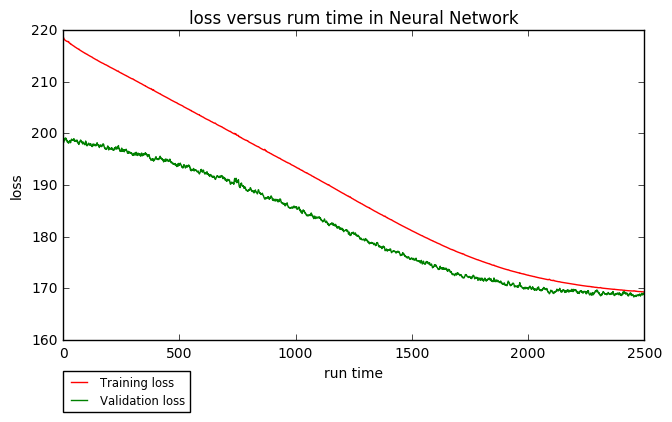

In [1106]:
fig, ax = plt.subplots() 
fig.set_size_inches(7.5, 4)
plt.plot(testRange, trainLosses*std_of_cnt+mean_of_cnt, 'r', label="Training loss")
plt.plot(testRange, validationLosses*std_of_cnt+mean_of_cnt, 'g', label="Validation loss")
plt.xlabel('run time')
plt.ylabel('loss')
plt.title("loss versus rum time in Neural Network")
plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0., fontsize='small')
plt.show()
plt.close()

## 绘制对验证集后21天的预测值与实际值的对比图

由于之前划分验证集时是直接取原有数据集的后18%作为验证集的，这里取验证集的后21天作为测试也相当于取原有数据集的后21天作为测试，保存了数据在时间上的连续性。

In [1084]:
num = 21*24 # 数据个数
last21Days_range = np.arange(num) #样本范围
last21Days_features, last21Days_labels = validateSet[-num:], validateSet_label[-num:]
#使用算法进行预测
last21Days_predicts = network.apply(last21Days_features)
#还原归一化后的数据
last21Days_predicts = last21Days_predicts.flatten()*std_of_cnt + mean_of_cnt
last21Days_labels = last21Days_labels.flatten()*std_of_cnt + mean_of_cnt

print(last21Days_predicts.shape, last21Days_labels.shape, last21Days_range.shape)

(504,) (504,) (504,)


In [1085]:
InteractiveShell.ast_node_interactivity = "none"

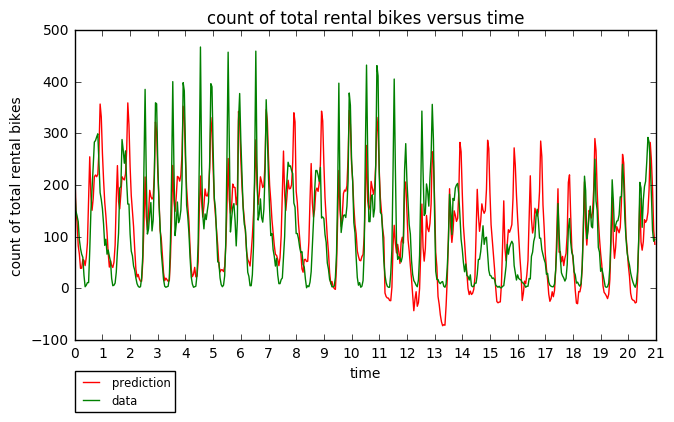

In [1102]:
fig, ax = plt.subplots() 
fig.set_size_inches(7.5, 4)
plt.plot(last21Days_range, last21Days_predicts, 'r', label="prediction")
plt.plot(last21Days_range, last21Days_labels, 'g', label="data")
ax.set_xlim(right=num)
ax.set_xticks(np.arange(0, num+24, 24))
ax.set_xticklabels(np.arange(0, 22, 1))
plt.xlabel('day')
plt.ylabel('count of total rental bikes')
plt.title("count of total rental bikes versus time")
plt.legend(bbox_to_anchor=(0, -0.1), loc=2, borderaxespad=0., fontsize='small')
plt.show()
plt.close()

从上面的输出可以看到，在全部21天(504个小时)中，除了在圣诞节前后预测值明显比实际值高很多之外，其他时间段的预测值和实际值还是比较贴近的。

## 在测试集上应用算法

基于上面调出来的最优参数，在测试集上运用该算法。

In [1055]:
test_predicts = network.apply(testSet).flatten()*std_of_cnt + mean_of_cnt
np.savetxt('15352220_linzecheng.txt', test_predicts, fmt="%.5f", delimiter="\n")

# 思考题

- 尝试说明下其他激活函数的优缺点。
    - 首先，需要明确，激活函数的主要作用是**加入非线性因素，解决线性模型的表达、分类能力不足的问题**。
    - **tanh激活函数**，表达式为`f(x)=2sigmoid(2x)-1`。
        - 优点：
            - 1.比Sigmoid函数收敛速度更快。
            - 2.相比Sigmoid函数，其输出以0为中心。
        - 缺点：
            - 1.和sigmoid函数一样都会出现梯度消失的问题。
    - **ReLU激活函数**，表达式为`f(x)=max(0,x)`
        - 优点：
            - 1.使用随机梯度下降训练算法时能更快收敛。
            - 2.有效缓解了梯度消失的问题。
            - 3.提供了神经网络的稀疏表达能力。
            - 4.相比于 sigmoid/tanh，ReLU只需要一个阈值就可以得到激活值，而不用进行许多复杂运算。
        - 缺点：
            - 1.随着训练的进行，可能会出现神经元死亡，权重无法更新的情况。如果发生这种情况，那么流经神经元的梯度从这一点开始将永远是0。也就是说，ReLU神经元在训练中不可逆地死亡了。
    - **Maxout激活函数**
        - 优点：
            - 1.拟合能力是非常强的，它可以拟合任意的的凸函数。
            - 2.计算简单，不会出现梯度消失的问题。
            - 3.不会出现在ReLU中会导致的神经元死亡的现象。
        - 缺点：
            - 1.引入了更多的参数，进一步加重调参的重担。
    - 除此之外还有许多激活函数，这里只讨论几个比较典型的以作为示例，分析思路基本都是一致的。



- 有什么方法可以实现传递过程中不激活所有节点？
    - 引入dropout方法，**在深度学习网络的训练过程中，对于神经网络单元，按照一定的概率将其暂时从网络中丢弃**。对于随机梯度下降来说，由于是随机丢弃，故而每一个mini-batch都在训练不同的网络。在这个过程中便实现了再传递过程中不激活所有节点。


- 梯度消失和梯度爆炸是什么？可以怎么解决？
    - 梯度爆炸和梯度消失问题都是因为**网络太深，网络权值更新不稳定**造成的，本质上是由**梯度反向传播中的连乘效应**导致的。
    - 梯度消失：误差从输出层反向传播时，在每一层都要乘以激活函数f(x)的导数。而若使用sigmoid函数作为激活函数，其导数的值域为[0, 0.25]，导数取值都小于1, **这样误差经过每一层传递都会不断地衰减。当网络导数比较多时，梯度会不断地衰减，甚至消失**，这使得整个网络很难训练。这就是梯度消失问题。
        - 解决方案：可以考虑用ReLU激活函数取代sigmoid激活函数。
    - 梯度爆炸：产生原因与梯度消失相反，**若激活函数f(x)的导数取值有很大的可能性会超过1，如此不断连乘下去，梯度将会指数级增长**。这就是梯度爆炸问题。
        - 解决方案：进行**梯度裁剪**，操作方法如下：
            - 选取一个梯度剪裁的阈值`clip_norm`（一般选择1）
            - 在计算完每个权重的梯度之后，我们并不像通常那样直接使用这些梯度进行权重更新，而是先求所有权重梯度的平方和`global_norm`
            - 最后把每个梯度乘以缩放因子` clip_norm/max(global_norm, clip_norm)`
            - 这样就**保证了在一次迭代更新中，所有权重的梯度的平方和在一个设定范围以内**。


# 参考资料

- 1.[用python参加Kaggle的些许经验总结][用python参加Kaggle的些许经验总结]
- 2.[Pandas 处理 dummy variable][Pandas 处理 dummy variable]
- 3.[数据标准化/归一化normalization][数据标准化/归一化normalization]
- 4.[Numpy中的广播(Broadcasting)][Numpy中的广播(Broadcasting)]
- 5.[NumPy v1.11 ManualNumPy参考例程随机抽样][NumPy v1.11 ManualNumPy参考例程随机抽样]
- 6.[深度神经网络中的梯度丢失和梯度爆炸][深度神经网络中的梯度丢失和梯度爆炸]
- 7.[深度神经网络的梯度不稳定问题--梯度消失与梯度爆炸][深度神经网络的梯度不稳定问题--梯度消失与梯度爆炸]
- 8.[python package - tqdm 4.14.0][tqdm 4.14.0]
- 9.[Homepage Machine Learning Algorithm 浅谈深度学习中的激活函数 - The Activation Function in Deep Learning][xxx]
- 10.[【机器学习】神经网络-激活函数-面面观(Activation Function)][【机器学习】神经网络-激活函数-面面观(Activation Function)]
- 11.[理解dropout][理解dropout]
- 12.[CS231n课程笔记翻译：神经网络笔记 2][CS231n课程笔记翻译：神经网络笔记 2]
- 13.[【深度学习】神经网络中的权重初始化：Why and How][【深度学习】神经网络中的权重初始化：Why and How]
- 14.[How to improve the neural networks accuracy?][How to improve the neural networks accuracy?]


[How to improve the neural networks accuracy?]:https://stackoverflow.com/questions/43347456/how-to-improve-the-neural-networks-accuracy/43347719
[【深度学习】神经网络中的权重初始化：Why and How]:http://www.jianshu.com/p/03009cfdf733
[CS231n课程笔记翻译：神经网络笔记 2]:https://zhuanlan.zhihu.com/p/21560667
[理解dropout]:http://blog.csdn.net/stdcoutzyx/article/details/49022443
[【机器学习】神经网络-激活函数-面面观(Activation Function)]:http://blog.csdn.net/cyh_24/article/details/50593400
[xxx]:http://www.cnblogs.com/rgvb178/p/6055213.html
[tqdm 4.14.0]:https://pypi.python.org/pypi/tqdm/4.14.0
[深度神经网络的梯度不稳定问题--梯度消失与梯度爆炸]:https://ziyubiti.github.io/2016/11/06/gradvanish/
[深度神经网络中的梯度丢失和梯度爆炸]:https://limengweb.wordpress.com/2017/03/12/%E6%B7%B1%E5%BA%A6%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%E4%B8%AD%E7%9A%84%E6%A2%AF%E5%BA%A6%E4%B8%A2%E5%A4%B1%E5%92%8C%E6%A2%AF%E5%BA%A6%E7%88%86%E7%82%B8/
[NumPy v1.11 ManualNumPy参考例程随机抽样]:http://usyiyi.cn/translate/NumPy_v111/reference/generated/numpy.random.choice.html
[用python参加Kaggle的些许经验总结]:http://www.jianshu.com/p/32def2294ae6
[Pandas 处理 dummy variable]:http://blog.csdn.net/weiwei9363/article/details/78255210
[数据标准化/归一化normalization]:http://blog.csdn.net/pipisorry/article/details/52247379
[Numpy中的广播(Broadcasting)]:http://blog.csdn.net/yangnanhai93/article/details/50127747

# 函数测试
在编写代码时，有许多地方需要用到矩阵运算来加快算法的运行速度，因此也必须要用到python的numpy库的一些函数。而在使用的过程中，遇到了一些与自己理解相异的用法，这里将其记录下来以便后续重温代码时能更好地理解代码。

## 列向量与行向量

在numpy中，不管是行向量还是列向量，均是用“行”向量进行表示的。若强行需要区分向量的维度，则可使用reshape函数进行调整。

In [760]:
InteractiveShell.ast_node_interactivity = "all"

In [761]:
2*np.ones(3) #新建 一维向量 时，默认创建 行向量

array([ 2.,  2.,  2.])

## np.dot()与行向量
np.dot()函数可实现两个行向量的点乘运算，也可实现numpy多维向量的矩阵运算。

    以下面的例子为例，a为 2 x 3 的矩阵，b为 1 x 3 的行向量，可用np.dot(a,b)进行两者的矩阵运算。

In [762]:
a = np.ones((2,3))
b = 2*np.ones(3)
a
b

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

array([ 2.,  2.,  2.])

从下面的输出可以看到，矩阵运算成功，同时输出结果由于只有“一行或一列”数据，numpy自动将其表示为了行向量。

In [763]:
np.dot(a,b)

array([ 6.,  6.])

从下面的输出也可以看到将 2 X 3 的矩阵与 1 X 2 的行向量进行点乘运算的报如下错误：

```ValueError: shapes (2,3) and (2,) not aligned: 3 (dim 1) != 2 (dim 0)```

In [764]:
c = 2*np.ones(2)
np.dot(a, c)

ValueError: shapes (2,3) and (2,) not aligned: 3 (dim 1) != 2 (dim 0)

## [:,None]切片

参考资料：[In numpy, what does selection by [:,None] do?][1]

[1]:https://stackoverflow.com/questions/37867354/in-numpy-what-does-selection-by-none-do

In [765]:
a = np.ones((2,3))
a
a[:,None]
a[:,None] == a[:, np.newaxis] # None和np.newaxis是等价的

array([[ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])

array([[[ 1.,  1.,  1.]],

       [[ 1.,  1.,  1.]]])

array([[[ True,  True,  True]],

       [[ True,  True,  True]]], dtype=bool)

In [766]:
b = np.ones(3)
b
b[:,np.newaxis]

array([ 1.,  1.,  1.])

array([[ 1.],
       [ 1.],
       [ 1.]])